# СЕМИНАР. Сверточные нейронные сети и Keras

<a name="0"></a>
<div><span style="font-size:14pt; font-weight:bold">Содержание</span>
    <br>
    <br>
    Часть 1: MNIST
    <ol>
        <li><a href="#1">Подготовка данных</a></li>
        <li><a href="#2">Softmax регрессия</a></li>
        <li><a href="#3">Сверточная нейронная сеть (CNN)</a>
            <ol style = "list-style-type:lower-alpha">
                <li><a href="#3a">Первый слой</a></li>
                <li><a href="#3b">Второй слой</a></li>
                <li><a href="#3c">Третий и четвертый слои</a></li>
                <li><a href="#3d">Обучение и тестирование</a></li>
                <li><a href="#3e">Dropout-регуляризация</a></li>
            </ol>
        </li>
    </ol>
    <br>
    Часть 2: CIFAR-10
    <ol>
        <li><a href="#4">Подготовка данных</a></li>
        <li><a href="#5">Построение сверточной нейронной сети</a></li>
    </ol>
    <a href="#6">Источники</a>
</div>

Импорт библиотек

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from keras.datasets import mnist,cifar10
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Activation, Flatten
from keras.optimizers import SGD, Adam
from keras.initializers import TruncatedNormal,Constant
from keras.preprocessing.image import ImageDataGenerator
from keras import utils
from keras.utils import np_utils

np.random.seed(555)

mnist_path = os.getcwd() + "/data/cnn-mnist-cifar10/" + "mnist.npz"
cifar10_path = os.getcwd() + "/data/cnn-mnist-cifar10/" + "cifar-10-python.tar.gz"
os.makedirs(os.getcwd() + "/data/cnn-mnist-cifar10", exist_ok=True)

Using TensorFlow backend.


<br><br>
# Часть 1: MNIST

<a name="1"></a>
## 1. Подготовка данных

Загрузка датасета MNIST

In [2]:
fn = mnist.get_file(mnist_path, "https://s3.amazonaws.com/img-datasets/mnist.npz")
(x_train, y_train), (x_test, y_test) = mnist.load_data(fn)

11493376/11490434 [==============================] - 10s 1us/step


Вывод ранодомного примера из датасета

<Figure size 216x216 with 0 Axes>

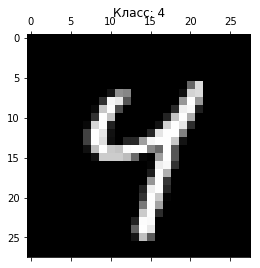

In [3]:
im = np.random.choice(len(x_train))
plt.figure(figsize=[3,3])
plt.matshow(x_train[im],  cmap="gray")
plt.title("Класс: %i" % y_train[im])
plt.show()

Масштабируем значения пикселей в пределах от 0.0 до 1.0, преобразуем картинку(матрицу) в вектор

In [ ]:
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
x_train /= 255
x_test /= 255
x_train = x_train.reshape(len(x_train), 784)
x_test = x_test.reshape(len(x_test), 784)

Оne-hot encoding - преобразуем метки классов в категориальные

In [ ]:
y_train = utils.to_categorical(y_train, 10)
y_test = utils.to_categorical(y_test, 10)

In [ ]:
print("Train: %i" % len(x_train))
print("Test: %i" % len(x_test))

<a name="2"></a>
## 2. Softmax регрессия

Создаем последовательную модель в Keras и добавляем слои

In [ ]:
# создаем модель
maxsoft_regressor = Sequential()
maxsoft_regressor.add(Dense(10, input_dim=784, activation="softmax", kernel_initializer="normal"))
maxsoft_regressor.summary()

Компилируем модель с выбранными оптимизатором, функцией потерь и метрикой, а далее обучаем модель

In [ ]:
optimizer = SGD(lr=0.5)
maxsoft_regressor.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
maxsoft_regressor.fit(x_train, y_train, batch_size=100, shuffle=True, verbose=1)

Тестирование модели на тестовой выборке

In [ ]:
acc = maxsoft_regressor.evaluate(x_test, y_test, verbose=0)
print("Точность: %.2f%%" % (acc[1]*100))

<a name="3"></a>
## 3. Convolutional neural network

Модель сверточной нейронной сети

<img src="images/cnn-mnist-cifar10/CNN.jpg" width="900px">

Конвертируем данные из вектора 1х784 в матрицу 28х28x1 [количество изображений, высота, ширина, количество каналов]

In [ ]:
x_train = x_train.reshape(len(x_train), 28, 28, 1)
x_test = x_test.reshape(len(x_test), 28, 28, 1)

<a name="3a"></a>
### a. Первый слой

Последовательности операций: Image[28x28x1] > CONV1 > ReLU > POOL1 > Image[14x14x32]

<img src="images/cnn-mnist-cifar10/Conv_L1.jpg" width="700px">

<div>
<p>Формирование слоя  CONV1:</p>
<ul>
    <li>количество фильтров - 32</li> 
    <li>размер фильтра - 5х5</li>
    <li>количество каналов - 1 (монохромное изображение)</li> 
    <li>шаг смещения - 1</li>
    <li>с сохранением исходной размеронсти данных (добавление нулей - padding) - да</li>
</ul>
</div>

СONV1: [-1,28,28,1] > CONV1 [5, 5, 1, 32] > [-1,28,28,32]

In [ ]:
# создаем последовательную модель нейронной сети
cnn = Sequential()

# добавляем сверточный слой
cnn.add(Conv2D(input_shape=(28,28,1), 
               filters=32, 
               kernel_size=(5,5), 
               padding="same",
               kernel_initializer=TruncatedNormal(stddev=0.1),
               use_bias=True,
               bias_initializer=Constant(0.1),
               activation="relu"))

POOL1: [-1,28,28,32] -> POOL1 -> [-1,14,14,32]

<div>
<p>Формирование слоя  POOL1:</p>
<ul>
    <li>размер фильтра - 2х2</li>
    <li>количество каналов - 32</li> 
    <li>шаг смещения - 2</li>
    <li>с сохранением исходной размеронсти данных (добавление нулей - padding) - да</li>
</ul>
</div>

In [ ]:
cnn.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding="same"))

<a name="3b"></a>
### b. Второй слой

Последовательности операций: Image[14x14x32] > CONV2 > ReLU > POOL2 > Image[7x7x64]

<img src="images/cnn-mnist-cifar10/Conv_L2.jpg" width="700px">

<div>
<p>Пример с тремям каналами и двумя фильтрами [<a href="http://cs231n.github.io/convolutional-networks/#conv">ссылка</a>]</p>
<img src="images/cnn-mnist-cifar10/CNN_3ch_2fil.png" width="700px">
</div>

<div>
<p>Формирование слоя  CONV2:</p>
<ul>
    <li>количество фильтров - 64</li> 
    <li>размер фильтра - 5х5</li>
    <li>количество каналов - 32 (от каждого фильтра из предыдущего слоя)</li> 
    <li>шаг смещения - 1</li>
    <li>с сохранением исходной размеронсти данных (добавление нулей - padding) - да</li>
</ul>
</div>

In [ ]:
cnn.add(Conv2D(filters=64, 
               kernel_size=(5,5), 
               padding="same",
               kernel_initializer=TruncatedNormal(stddev=0.1),
               use_bias=True,
               bias_initializer=Constant(0.1),
               activation="relu"))

In [ ]:
cnn.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding="same"))

<a name="3c"></a>
### c. Третий и четвертый слои

Представление изображений в виде одномерного массива
<img src="images/cnn-mnist-cifar10/Data_Repr_FCL.jpg" width="300px">

Последовательности операций: Image[7\*7\*64x1] > FC ReLU > FC Softmax > Probability[10x1]
<img src="images/cnn-mnist-cifar10/FC_L3_L4.jpg" width="800px">

In [ ]:
# Третий слой
cnn.add(Flatten()) # преобразуем изображение(карту) в одномерный массив
cnn.add(Dense(1024, kernel_initializer=TruncatedNormal(stddev=0.1),
              use_bias=True,
              bias_initializer=Constant(0.1),
              activation="relu"))

In [ ]:
# Четвертый слой
cnn.add(Dense(10, kernel_initializer=TruncatedNormal(stddev=0.1),
              use_bias=True,
              bias_initializer=Constant(0.1), 
              activation="softmax"))

In [ ]:
# вывод информации о полученной модели
cnn.summary()

<a name="3d"></a>
### d. Обучение и тестирование

<p>Итеративный процесс обучения:</p>
<ul>
    <li>всего изображений в обучающем подмножестве - 60000
        <ul>
            <li>обучающая выборка: 57000</li>
            <li>валидационная выборка: 3000</li>
        </ul>
    </li>
    <li>всего изображений в тестовом подмножестве - 10000</li>
    <li>размер batch'а - 100</li>
    <li>всего batch'ей - 10000 (возможны повторы)</li>
    <li>количество эпох - 18</li>
</ul>

In [ ]:
# Компилируем модель
cnn.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# Создаем генератор изображений
gen = ImageDataGenerator(validation_split=0.05)
# Генератор для обучения
train_gen = gen.flow(x_train, y_train, batch_size=100, shuffle=True, subset="training")
# Генератор для валидации
valid_gen = gen.flow(x_train, y_train, batch_size=100, shuffle=True, subset="validation")

In [ ]:
# Обучаем модель (с генератором изображений)
hist = cnn.fit_generator(train_gen, steps_per_epoch=10000, 
                  validation_data=valid_gen, validation_steps=10000,
                  epochs=18, verbose=1)

In [ ]:
# Визуализация процесса обучения - построение графиков зависимости ошибки и точности от эпохи
plt.plot(hist.history["loss"], label="Ошибка на обучающей выборке")
plt.plot(hist.history["val_loss"], label="Ошибка на валидационной выборке")
plt.xlabel("Эпоха")
plt.ylabel("Ошибка")
plt.legend()
plt.show()
plt.plot(hist.history["acc"], label="Точность на обучающей выборке")
plt.plot(hist.history["val_acc"], label="Точность на валидационной выборке")
plt.xlabel("Эпоха")
plt.ylabel("Точность")
plt.legend()
plt.show()

In [ ]:
# Тестирование модели
cnn.evaluate(x_test, y_test, verbose=0)
print("Точность: %.2f%%" % (scores[1]*100))

<a name="3e"></a>
### e. Dropout регуляризация

In [ ]:
# сохраняем и удаляем из модели последний слой (softmax)
lay = cnn.layers[len(cnn.layers)-1]
cnn.pop()

# добавляем dropout
cnn.add(Dropout(0.5))

# возвращаем последний слой (softmax)
cnn.add(lay)

# Компилируем модель
cnn.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"])

cnn.summary()

In [ ]:
# Обучаем модель
hist = cnn.fit_generator(train_gen, steps_per_epoch=10000, 
                  validation_data=valid_gen, validation_steps=10000,
                  epochs=18, 
                  verbose=2)

In [ ]:
# Визуализация процесса обучения - построение графиков зависимости ошибки и точности от эпохи
plt.plot(hist.history["loss"], label="Ошибка на обучающей выборке")
plt.plot(hist.history["val_loss"], label="Ошибка на валидационной выборке")
plt.xlabel("Эпоха")
plt.ylabel("Ошибка")
plt.legend()
plt.show()
plt.plot(hist.history["acc"], label="Точность на обучающей выборке")
plt.plot(hist.history["val_acc"], label="Точность на валидационной выборке")
plt.xlabel("Эпоха")
plt.ylabel("Точность")
plt.legend()
plt.show()

In [ ]:
# Тестирование модели
cnn.evaluate(x_test, y_test, verbose=0)
print("Точность: %.2f%%" % (scores[1]*100))

In [ ]:
# Сделаем предсказание для произвольного примера и сравним с истинной меткой класса
rand_test = np.random.choice(x_test.index)
s = x_test[rand_test]
s = s.reshape(1, len(s))
pred = np.argmax(model.predict(s), axis=-1)
plt.matshow(x_test[rand_test].reshape(28, 28), cmap="grey")
plt.set_title("Класс: %i" % y_test.loc[rand_test])
plt.grid(False)

<br><br>
# Часть 2: CIFAR-10

<a name="4"></a>
## 1. Подготовка данных

Загрузка датасета

In [4]:
#fn = cifar10.get_file(cifar10_path, "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz")
(x_train, y_train),(x_test, y_test) = cifar10.load_data() # датасет загрузится в ~/.keras/datasets/
classes = {0:"airplane", 1:"automobile", 2:"bird", 3:"cat", 4:"deer", 
           5:"dog", 6:"frog", 7:"horse", 8:"ship", 9:"truck"}

170500096/170498071 [==============================] - 74s 0us/step


Предобработка данных

In [5]:
# масштабируем значения пикселей в диапазон от 0.0 до 1.0
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# one-hot encoding
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

Класс: truck


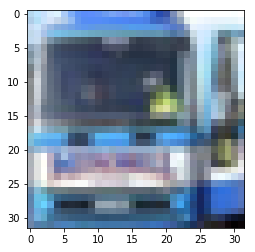

In [6]:
# вывод рандомного примера из обучающего множества
ind = np.random.choice(len(x_train))
plt.imshow(x_train[ind])
print("Класс: %s" % classes[np.argmax(y_train[ind])])

<a name="5"></a>
## 2. Построение сверточной нейронной сети

Параметры для обучения и тестирования нейронной сети

In [ ]:
# Размер мини-выборки
batch_size = 32
# Количество классов изображений
classes = 10
# Количество эпох для обучения
num_epochs = 30
# Размер изображения
img_h, img_w = 32, 32
# Количество каналов в изображении
img_ch = 3

Строим модель сверточной нейронной сети

In [ ]:
# Создаем последовательную модель
cnn2 = Sequential()
# Первый сверточный слой
cnn2.add(Conv2D(64, (3, 3), padding='same',
                        input_shape=(32, 32, 3), activation='relu'))
# Второй сверточный слой
cnn2.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
# Первый слой подвыборки
cnn2.add(MaxPool2D(pool_size=(2, 2)))
# Слой регуляризации Dropout
cnn2.add(Dropout(0.4))

# Третий сверточный слой
cnn2.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
# Четвертый сверточный слой
cnn2.add(Conv2D(256, (3, 3), activation='relu'))
# Второй слой подвыборки
cnn2.add(MaxPool2D(pool_size=(2, 2)))
# Слой регуляризации Dropout
cnn2.add(Dropout(0.4))
# Слой преобразования данных из двумерного представления в вектор
cnn2.add(Flatten())
# Полносвязный слой для классификации
cnn2.add(Dense(1024, activation='relu'))
# Слой регуляризации Dropout
cnn2.add(Dropout(0.7))
# Выходной полносвязный слой Softmax
cnn2.add(Dense(classes, activation='softmax'))

Вывод информации о структуре полученной сети

In [ ]:
cnn2.summary()

Выбор оптимизатора и комапиляция модели

In [ ]:
sgd = Adam()
cnn2.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

Обучение: 90%-обучающая выборка, 10%-валидационная выборка

In [ ]:
# Обучение модели (без генератора изображений)
%%time
hist = cnn2.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=num_epochs,
          validation_split=0.1,
          shuffle=True,
          verbose=1)

In [ ]:
# Визуализация процесса обучения - построение графиков зависимости ошибки и точности от эпохи
plt.plot(hist.history["loss"], label="Ошибка на обучающей выборке")
plt.plot(hist.history["val_loss"], label="Ошибка на валидационной выборке")
plt.xlabel("Эпоха")
plt.ylabel("Ошибка")
plt.legend()
plt.show()
plt.plot(hist.history["acc"], label="Точность на обучающей выборке")
plt.plot(hist.history["val_acc"], label="Точность на валидационной выборке")
plt.xlabel("Эпоха")
plt.ylabel("Точность")
plt.legend()
plt.show()

Модель можно обучать дальше для повышения точности классификации (до тех пор пока не пойдет переобучение сети)

Оценка точности классификации

In [ ]:
# Тестирование модели
scores = cnn2.evaluate(x_test, y_test, verbose=2)
print("Точность: %.2f%%" % (scores[1]*100))

Сохранение сети в файл и загрузка из файла

In [ ]:
model_path = "./models/cnn-mnist-cifar10/cnn_cifar10_model.h5"
# сохранение обученной модели в файл
cnn2.save(model_path)

# загрузка сохраненной модели из файла
#cnn2 = load_model(model_path)
#scores = cnn2.evaluate(x_test, y_test, verbose=0)
#print("Точность: %.2f%%" % (scores[1]*100))

In [ ]:
# вывод предсказания для произвольного примера и его истинную метку класса
t = np.random.choice(len(x_test))
plt.imshow(x_test[t])
print("Истинный класс: " + classes[np.argmax(y_test[t])])
print("Предсказанный класс: " + classes[np.argmax(cnn2.predict(np.expand_dims(x_test[t], axis=0)))])

<a name="6"></a>
## Источники

<div>
<a href="https://www.tensorflow.org/get_started/mnist/beginners">MNIST For ML Beginners</a><br>
<a href="https://www.tensorflow.org/get_started/mnist/pros">Deep MNIST for Experts</a><br>
<a href="https://www.tensorflow.org/tutorials/deep_cnn">Convolutional Neural Networks</a><br>
<a href="http://cs231n.github.io/convolutional-networks/">Convolutional Neural Networks (CNNs / ConvNets)</a><br>
<a href="http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf">ImageNet Classification with Deep Convolutional Neural Networks (PDF)</a><br>
<a href="https://keras.io/getting-started/functional-api-guide/">Keras API Introduction</a><br>
<a href="https://keras.io/getting-started/sequential-model-guide/">Keras Sequential Model Guide</a><br>
<a href="https://keras.io/datasets/">Keras Datasets</a>
</div>